In [ ]:
! pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('drive')


Mounted at drive


In [ ]:
def load_images_and_masks(img_path, mask_path, start_index=0, end_index=None):
    img_files = sorted(os.listdir(img_path))[start_index:end_index]
    mask_files = sorted(os.listdir(mask_path))

    mask_dict = {os.path.splitext(mask)[0]: mask for mask in mask_files}

    image_list, mask_list = [], []
    for img_file in img_files:
        img_base = os.path.splitext(img_file)[0]
        img_full_path = os.path.join(img_path, img_file)
        try:
            image = Image.open(img_full_path).convert('RGB')
        except IOError:
            print(f"Failed to load image: {img_file}")
            continue



        if img_base in mask_dict:
            mask_full_path = os.path.join(mask_path, mask_dict[img_base])
            try:
                mask = Image.open(mask_full_path).convert('L')  # Convert to grayscale
            except IOError:
                print(f"Failed to load mask: {mask_full_path}")
                mask = None
        else:
            mask = None



        image_list.append(np.array(image))
        mask_list.append(np.array(mask) if mask is not None else None)

    return image_list, mask_list



train_image_folder = "/content/drive/MyDrive/oem_data/trainset/images/"
train_mask_folder = "/content/drive/MyDrive/oem_data/trainset/labels/"
val_image_folder = "/content/drive/MyDrive/oem_data/valset/images/"
val_mask_folder = "/content/drive/MyDrive/oem_data/valset/labels/"



train_images, train_masks = load_images_and_masks(train_image_folder, train_mask_folder, 0, 200)
pseudo_test_images, pseudo_test_masks = load_images_and_masks(train_image_folder, train_mask_folder, 200, 258)
val_images, val_masks = load_images_and_masks(val_image_folder, val_mask_folder)




Visualizing  val Data Samples:
unique mask [0 1 2 4 5 6 7]
unique mask [0 1 2 3 5 6 7]
unique mask [0 1 2 3 5 6 7]
unique mask [0 1 2 4 5 6 7]
unique mask [0 1 2 5 6 7]
unique mask [0 1 2 5 6 7]
unique mask [0 1 2 5 7]
unique mask [0 1 2 3 4 5 6 7]
unique mask [0 1 2 3 4 5 6 7]
unique mask [0 1 2 4 5 6 7]
unique mask [0 1 2 4 5 7]
unique mask [0 1 2 4 5 6 7]


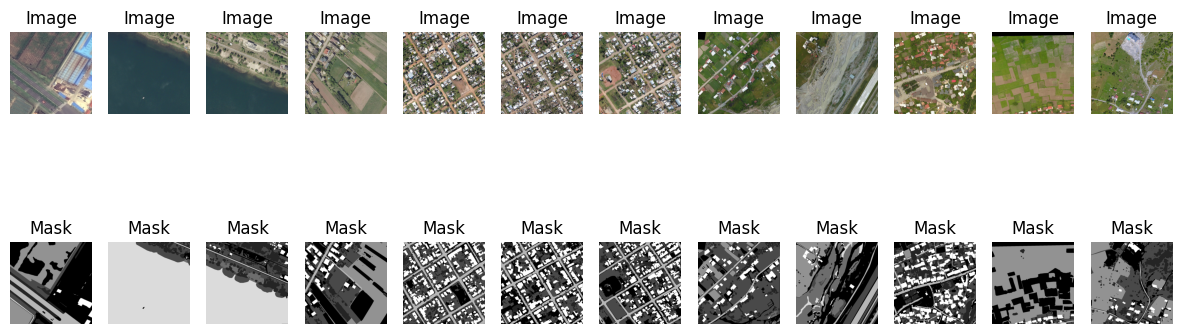

In [ ]:


def check_data(images, masks, expected_num, label="Training"):
    print(f"--- {label} Data Check ---")
    if len(images) != expected_num:
        print(f"Error: Expected {expected_num} images, but got {len(images)}.")
    else:
        print(f"Number of images: {len(images)}")

    if masks:
        if len(images) == len(masks):
            print(f"Number of masks matches the number of images.")
        else:
            print(f"Error: Number of images and masks do not match.")
    else:
        print("No masks to check.")


    if images:
        print(f"Sample image shape: {images[0].shape}")
        print(f"Sample image dtype: {images[0].dtype}")
    if masks and masks[0] is not None:
        print(f"Sample mask shape: {masks[0].shape}")
        print(f"Sample mask dtype: {masks[0].dtype}")

def visualize_sample(images, masks, num_samples=12):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, 20)):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(images[i])
        plt.title('Image')
        plt.axis('off')

        if masks and masks[i] is not None:
            print("unique mask",np.unique(masks[i]))
            plt.subplot(2, num_samples, num_samples+i+1)
            plt.imshow(masks[i], cmap='gray')
            plt.title('Mask')
            plt.axis('off')
    plt.show()
   # plt.savefig("vis_pseudo.png")

#check_data(val_images, val_masks, 20, "val")
print("Visualizing  val Data Samples:")
#visualize_sample(val_images, val_masks)
visualize_sample(pseudo_test_images, pseudo_test_masks)

### for pseudo_test data
# def visualize_sample(images, masks, num_samples=58):
#     plt.figure(figsize=(25, 25))  # Adjust the size to fit 58 images
#     for i in range(num_samples):
#         plt.subplot(12, 10, i+1)  # Change grid dimensions to accommodate 58 images
#         plt.imshow(images[i])
#         plt.title('Image')
#         plt.axis('off')

#         plt.subplot(12, 10, num_samples+i+1)
#         plt.imshow(masks[i], cmap='gray')
#         plt.title('Mask')
#         plt.axis('off')
#     plt.show()
   # plt.savefig("vis_pseudo.png")

#check_data(pseudo_test_images,pseudo_test_masks,58)

#visualize_sample(pseudo_test_images, pseudo_test_masks)





## custom dataset

In [ ]:
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, images, masks=None, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx] if self.masks is not None and self.masks[idx] is not None else None


        image = Image.fromarray(image) if not isinstance(image, Image.Image) else image
        if mask is not None:
            mask = Image.fromarray(mask) if not isinstance(mask, Image.Image) else mask


        if self.image_transform:
            image = self.image_transform(image)
        if mask is not None and self.mask_transform:
            mask = self.mask_transform(mask)
            mask = torch.squeeze(mask, 0)
            mask = mask.long()

        return image, mask


image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



def mask_to_tensor(mask):
    unique_labels = torch.unique(mask)
   # print("unique labels",unique_labels)
    mask_tensor = torch.zeros_like(mask, dtype=torch.int64)
    for label in unique_labels:
      #  print("label",label)
        mask_tensor[mask == label] = label
    return mask_tensor

mask_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST),
    lambda x: mask_to_tensor(torch.tensor(np.array(x)))  # Convert PIL Image to tensor
])


# uncomment the following to check the unique values in mask (before transform and after transform)

# sample_mask1 = Image.open("/content/drive/MyDrive/oem_data/trainset/labels/abancay_26.tif")
# #/content/drive/MyDrive/oem_data/trainset/labels/aachen_20.tif")
# unique_values_sample1 = np.unique(sample_mask1)
# print("Unique values in the mask tensor:", unique_values_sample1)
# sample_mask2 = mask_transform(Image.open("/content/drive/MyDrive/oem_data/trainset/labels/abancay_26.tif"))
# unique_values_sample2 = torch.unique(sample_mask2)
# print("Unique values in the mask tensor:", unique_values_sample2)





In [ ]:


train_dataset = CustomDataset(train_images, train_masks, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = CustomDataset(val_images, val_masks, image_transform=image_transform, mask_transform=mask_transform)
pseudo_test_dataset= CustomDataset(pseudo_test_images, pseudo_test_masks, image_transform=image_transform, mask_transform=mask_transform)



train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
pseudo_test_loader = DataLoader(pseudo_test_dataset, batch_size=2, shuffle=False)





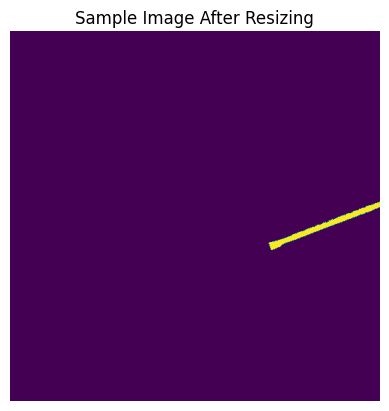

<Figure size 640x480 with 0 Axes>

In [ ]:

def display_sample(dataset):
    image, mask = dataset[0]  # Getting the first sample from the dataset
    image = image.permute(1, 2, 0)  # Rearrange channels for plotting
 #   print("unique",np.unique(mask))
    plt.imshow(mask.numpy())
    plt.title('Sample Image After Resizing')
    plt.axis('off')
    plt.show()
    plt.savefig("resized.png")

#display_sample(pseudo_test_dataset)
display_sample(val_dataset)








..

.............
................

In [ ]:
# segmentation model
model = smp.DeepLabV3(
    encoder_name="resnet101", # or "resnet34", "mobilenet_v2", etc.
    encoder_weights="imagenet", # or `None` for random initialization
    in_channels=3, # number of input channels
    classes=8, # number of classes
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss() # for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# num_epochs = 2
# # Initialize the segmentation model
# model = smp.DeepLabV3(
#     encoder_name="resnet101", # or "resnet34", "mobilenet_v2", etc.
#     encoder_weights="imagenet", # or `None` for random initialization
#     in_channels=3, # number of input channels
#     classes=8, # number of classes, excluding the background if it's not considered a class
# )

# # Move the model to the GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define loss function, optimizer, and learning rate scheduler
# criterion = nn.CrossEntropyLoss() # for multi-class segmentation
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#     # Validation step, if needed
#     # ...

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 173MB/s]


Epoch [1/2], Loss: 0.2943568229675293
Epoch [2/2], Loss: 0.12320488691329956


In [ ]:
## keeping 20 val images
import os


images_dir = "/content/drive/MyDrive/oem_data/valset/images"
labels_dir = "/content/drive/MyDrive/oem_data/valset/labels"


images_files = {os.path.splitext(file)[0] for file in os.listdir(images_dir)}
labels_files = {os.path.splitext(file)[0] for file in os.listdir(labels_dir)}


files_to_delete = images_files - labels_files
print(files_to_delete)
print(len(files_to_delete))

for file in files_to_delete:

    file_path = os.path.join(images_dir, file + ".tif")
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted {file_path}")
    else:
        print(f"File not found: {file_path}")

print("Deletion of non-common files is complete.")

{'maputo_6', 'ngaoundere_36', 'lohur_29', 'rotterdam_22', 'lima_15', 'muenster_60', 'kyoto_68', 'lohur_11', 'lubuskie_23', 'kyoto_18', 'accra_29', 'monrovia_29', 'shanghai_26', 'rotterdam_21', 'al_qurnah_62', 'svaneti_13', 'lohur_7', 'tokyo_63', 'tonga_64', 'kyoto_65', 'santiago_62', 'rio_7', 'bielefeld_69', 'rotterdam_10', 'tonga_48', 'shanghai_65', 'dolnoslaskie_38', 'kyoto_50', 'duesseldorf_58', 'slaskie_28'}
30
Deleted /content/drive/MyDrive/oem_data/valset/images/maputo_6.tif
Deleted /content/drive/MyDrive/oem_data/valset/images/ngaoundere_36.tif
Deleted /content/drive/MyDrive/oem_data/valset/images/lohur_29.tif
Deleted /content/drive/MyDrive/oem_data/valset/images/rotterdam_22.tif
Deleted /content/drive/MyDrive/oem_data/valset/images/lima_15.tif
Deleted /content/drive/MyDrive/oem_data/valset/images/muenster_60.tif
Deleted /content/drive/MyDrive/oem_data/valset/images/kyoto_68.tif
Deleted /content/drive/MyDrive/oem_data/valset/images/lohur_11.tif
Deleted /content/drive/MyDrive/oem

In [ ]:
import matplotlib.pyplot as plt

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

    avg_loss = running_loss / len(loader.dataset)
    return avg_loss

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_prediction_maps(loader, model, device, folder="predictions"):
    import os
    os.makedirs(folder, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for idx, (images, _) in enumerate(loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            for i, pred in enumerate(preds):
                plt.imshow(pred.cpu(), cmap='gray')
                plt.axis('off')
                plt.savefig(f"{folder}/prediction_{idx*loader.batch_size + i}.png")
                plt.close()




## Training

In [ ]:
# Training loop
num_epochs = 20
train_losses = []
#val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

  #  val_loss = validate(model, val_loader, criterion, device)
 #   val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')
    #Validation Loss: {val_loss:.4f}')



Epoch [1/20], Training Loss: 1.4396
Epoch [2/20], Training Loss: 1.4236
Epoch [3/20], Training Loss: 1.3870
Epoch [4/20], Training Loss: 1.4211
Epoch [5/20], Training Loss: 1.4139
Epoch [6/20], Training Loss: 1.3704
Epoch [7/20], Training Loss: 1.3540
Epoch [8/20], Training Loss: 1.3039
Epoch [9/20], Training Loss: 1.3318
Epoch [10/20], Training Loss: 1.3131
Epoch [11/20], Training Loss: 1.3198
Epoch [12/20], Training Loss: 1.2665
Epoch [13/20], Training Loss: 1.2891
Epoch [14/20], Training Loss: 1.2462
Epoch [15/20], Training Loss: 1.2439
Epoch [16/20], Training Loss: 1.2252
Epoch [17/20], Training Loss: 1.2436
Epoch [18/20], Training Loss: 1.1676
Epoch [19/20], Training Loss: 1.2323
Epoch [20/20], Training Loss: 1.2321


In [ ]:
# Assuming the model, train_loader, and device are already defined and available

# # Move the model to evaluation mode
# model.eval()

# # Get the last batch from the training loader
# last_images, last_masks = next(iter(reversed(list(train_loader))))

# # Move the images to the correct device
# last_images = last_images.to(device)

# # Generate predictions
# with torch.no_grad():
#     last_outputs = model(last_images)

# # Convert outputs to predicted class indices
# preds = torch.argmax(last_outputs, dim=1).cpu().numpy()

# # Visualize predictions
# fig, axs = plt.subplots(1, len(preds), figsize=(15, 5))
# for i, pred in enumerate(preds):
#     ax = axs[i] if len(preds) > 1 else axs
#     ax.imshow(pred, cmap='viridis')
#     ax.axis('off')
#     ax.set_title(f'Prediction {i+1}')

# plt.show()
# fig.savefig("last_batch_predictions.png")  # Save the figure of last batch predictions


Unique values in actual masks: [0 1 2 4 5 6 7]
len pred 2


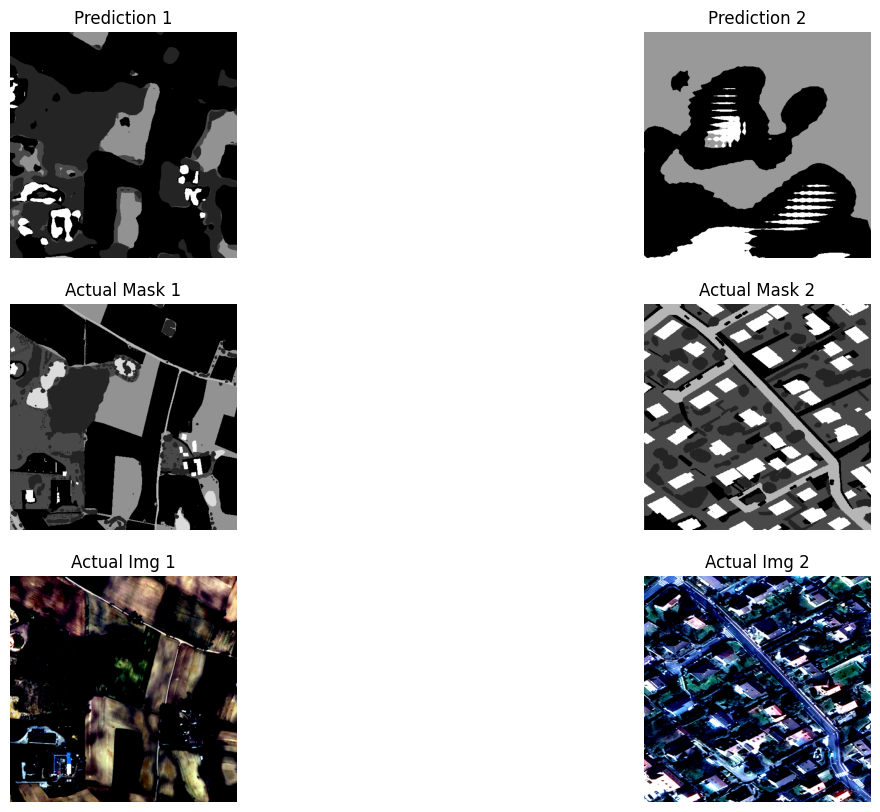

In [ ]:
## visualization block
# Move the model to evaluation mode
model.eval()

# Get the last batch from the training loader
last_images, last_masks= next(iter(reversed(list(train_loader))))


last_images = last_images.to(device)
last_masks = last_masks.to(device)


with torch.no_grad():
    last_outputs = model(last_images)

# Converting outputs to predicted class indices
imgs = last_images.cpu().numpy()
preds = torch.argmax(last_outputs, dim=1).cpu().numpy()
actuals = last_masks.cpu().numpy()
print("Unique values in actual masks:", np.unique(actuals))
# Visualize predictions and actual masks
fig, axs = plt.subplots(3, len(preds), figsize=(15, 10))
print("len pred",len(preds))
for i in range(len(preds)):

    # preds
    axs[0, i].imshow(preds[i], cmap='gray')  #
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Prediction {i+1}')

    # actual masks
    axs[1, i].imshow(actuals[i], cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Actual Mask {i+1}')

    #imgs
    img = np.transpose(imgs[i], (1, 2, 0))
    axs[2, i].imshow(img)
    axs[2, i].axis('off')
    axs[2, i].set_title(f'Actual Img {i+1}')

plt.show()
fig.savefig("last_batch_predictions_and_masks.png")


In [ ]:
### on unseen data  ####


num_epochs = 8

pseudo_test_losses = []

for epoch in range(num_epochs):
    model.eval()
    running_loss = 0.0
    for images, masks in pseudo_test_loader:
        images = images.to(device)
        masks = masks.to(device)

        with torch.no_grad():
          outputs = model(images)
          loss = criterion(outputs, masks)
          running_loss += loss.item() * images.size(0)

    pseudo_test_loss = running_loss / len(pseudo_test_loader.dataset)
    pseudo_test_losses.append(pseudo_test_loss)

  #  val_loss = validate(model, val_loader, criterion, device)
 #   val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val_my_pseudo_test Loss: {pseudo_test_loss:.4f}')

Epoch [1/8], Val_my_pseudo_test Loss: 72.2416
Epoch [2/8], Val_my_pseudo_test Loss: 72.2416
Epoch [3/8], Val_my_pseudo_test Loss: 72.2416
Epoch [4/8], Val_my_pseudo_test Loss: 72.2416
Epoch [5/8], Val_my_pseudo_test Loss: 72.2416
Epoch [6/8], Val_my_pseudo_test Loss: 72.2416
Epoch [7/8], Val_my_pseudo_test Loss: 72.2416
Epoch [8/8], Val_my_pseudo_test Loss: 72.2416


In [ ]:
#plot_losses(train_losses, pseudo_test_losses)


save_prediction_maps(pseudo_test_loader, model, device)

In [ ]:
# def check_logits_and_predictions(loader, model, device="cuda"):
#     model.eval()
#     examples = next(iter(loader))
#     inputs, _ = examples
#     inputs = inputs.to(device)

#     with torch.no_grad():
#         outputs, _ = model(inputs)


#         print("Sample logits:", outputs[0])
#         print("Sample logits shape:", outputs[0].shape)

#         probs = F.softmax(outputs, dim=1)
#         print("Sample probabilities:", probs[0])


#         preds = torch.argmax(probs, dim=1)  # Convert probabilities to class predictions
#         print("Sample predictions:", preds[0])
#         print("Unique predicted classes in the batch:", torch.unique(preds))

#     return preds

In [ ]:
# check_logits_and_predictions(train_loader, model, device)

Sample logits: tensor([[3.1378, 3.1818, 3.2259,  ..., 3.1232, 3.0212, 2.9191],
        [3.2851, 3.3331, 3.3811,  ..., 3.2451, 3.1370, 3.0289],
        [3.4323, 3.4843, 3.5363,  ..., 3.3669, 3.2528, 3.1388],
        ...,
        [3.7130, 3.7822, 3.8514,  ..., 3.4679, 3.3372, 3.2066],
        [3.5603, 3.6274, 3.6946,  ..., 3.3458, 3.2200, 3.0942],
        [3.4075, 3.4727, 3.5378,  ..., 3.2237, 3.1028, 2.9818]],
       device='cuda:0')
Sample logits shape: torch.Size([512, 512])
Sample probabilities: tensor([[0.0007, 0.0007, 0.0007,  ..., 0.0009, 0.0009, 0.0010],
        [0.0008, 0.0008, 0.0008,  ..., 0.0010, 0.0011, 0.0011],
        [0.0009, 0.0009, 0.0009,  ..., 0.0012, 0.0012, 0.0012],
        ...,
        [0.0012, 0.0012, 0.0012,  ..., 0.0013, 0.0013, 0.0013],
        [0.0011, 0.0011, 0.0010,  ..., 0.0011, 0.0012, 0.0012],
        [0.0009, 0.0009, 0.0009,  ..., 0.0010, 0.0010, 0.0010]],
       device='cuda:0')
Sample predictions: tensor([421, 421, 421, 421, 421, 414, 414, 414, 414, 41

tensor([[421, 421, 421,  ..., 503, 503, 503],
        [  0,   0,   0,  ..., 511, 511, 511],
        [  0,   0,   0,  ..., 511, 511, 511],
        ...,
        [  0,   0,   0,  ..., 511, 511, 511],
        [  0, 511, 511,  ..., 511, 511, 511],
        [511, 511, 511,  ..., 511, 511, 511]], device='cuda:0')